- 本Notebook主要用于:
    + Bge 向量模型的选型、调优，效果对比分析
    + Bge Rerank模型的微调、效果对比分析

**结合blog[<基于大语言模型知识问答应用落地实践 - 知识召回调优(下)>](https://aws.amazon.com/cn/blogs/china/practice-of-knowledge-question-answering-application-based-on-llm-knowledge-base-construction-part-4/)使用**

In [ ]:
!pip install git+https://github.com/FlagOpen/FlagEmbedding.git -Uq
!pip install -Uq sentence-transformers 
!pip install faiss-cpu -Uq

### Generate random negative label

基于LLM增强的数据输入，生成BGE向量模型训练的数据，采用随机负采样的方式

**LLM增强的输入数据(chatgpt_synthesis.jsonl)格式如下** 
```
{
    "origin_question": "什么是 EMR Studio？", 
    "origin_answer": "EMR Studio 是一个集成开发环境 (IDE)，使数据科学家和数据工程师能够轻松地开发、可视化和调试用 R、Python、Scala 和 PySpark 编写的数据工程和数据科学应用程序。\n它是一个完全托管的应用程序，具有单点登录、完全托管的 Jupyter Notebooks、自动基础设施预置，并且能够在不登录 AWS 控制台或集群的情况下调试作业。数据科学家和分析人员可以安装自定义内核和库，使用代码库（如 GitHub 和 BitBucket）与同事协作，或者使用 Apache Airflow、AWS Step Functions 和 Amazon Managed Workflows for Apache Airflow 等编排服务，将参数化笔记本作为计划工作流的一部分运行。 您可以使用 Amazon MWAA 读取 Amazon EMR 笔记本上的编排分析作业，以了解更多信息。EMR Studio 内核和应用程序在 EMR 集群上运行，因此您可以利用性能优化的适用于 Apache Spark 的 Amazon EMR 运行时，获得分布式数据处理带来的优势。管理员可以设置 EMR Studio，以便分析师可以在现有 EMR 集群上运行其应用程序，或使用 EMR 的预定义 AWS CloudFormation 模板创建新集群。", 
    "generate_question": "EMR Studio 是用来做什么的？", 
    "generate_answer": "EMR Studio 是一个集成开发环境 (IDE)，用于开发、可视化和调试数据工程和数据科学应用程序。"
}
{
    "origin_question": "什么是 EMR Studio？", 
    "origin_answer": "EMR Studio 是一个集成开发环境 (IDE)，使数据科学家和数据工程师能够轻松地开发、可视化和调试用 R、Python、Scala 和 PySpark 编写的数据工程和数据科学应用程序。\n它是一个完全托管的应用程序，具有单点登录、完全托管的 Jupyter Notebooks、自动基础设施预置，并且能够在不登录 AWS 控制台或集群的情况下调试作业。数据科学家和分析人员可以安装自定义内核和库，使用代码库（如 GitHub 和 BitBucket）与同事协作，或者使用 Apache Airflow、AWS Step Functions 和 Amazon Managed Workflows for Apache Airflow 等编排服务，将参数化笔记本作为计划工作流的一部分运行。 您可以使用 Amazon MWAA 读取 Amazon EMR 笔记本上的编排分析作业，以了解更多信息。EMR Studio 内核和应用程序在 EMR 集群上运行，因此您可以利用性能优化的适用于 Apache Spark 的 Amazon EMR 运行时，获得分布式数据处理带来的优势。管理员可以设置 EMR Studio，以便分析师可以在现有 EMR 集群上运行其应用程序，或使用 EMR 的预定义 AWS CloudFormation 模板创建新集群。", 
    "generate_question": "EMR Studio 支持哪些编程语言？",
    "generate_answer": "EMR Studio 支持 R、Python、Scala 和 PySpark 这些编程语言。"
}
```

In [99]:
# use LLM enhanced data
import random
import json
import os
FAQ_FILE = 'chatgpt_synthesis.jsonl'

def generate_train_data(train_data, output_suffix='train'):
    size_train_data = len(train_data)
    qq_labels = []
    gqga_labels = []
    gqoa_labels = []
    for line in train_data:
        json_obj = json.loads(line)
        
        o_query = json_obj['origin_question'].strip()
        o_answer = json_obj['origin_answer']
        g_query = json_obj['generate_question']
        g_answer = json_obj['generate_answer']
        
        # 可能的召回策略是：
        # 知识库构建时，o_query，g_query，o_answer，g_answer 均做向量化。
        # 查询时去做QQ召回，QA召回
        
        # 求 origin_Q - generated_Q 的相似性， 判断QQ召回的可行性
        qq_labels.append((o_query, g_query)) 
        
        #求 origin_Q - generated_D 的相似性， 判断QD召回的可行性
        gqga_labels.append((g_query, g_answer)) 
        
        #求 origin_Q - origin_D 的相似性， 判断QD召回的可行性
        gqoa_labels.append((g_query, o_answer))
        
    qq1_file = open(f"chatgpt_synthesis/qq1_{output_suffix}.jsonl", 'w')
    for idx, (query_a, query_b) in enumerate(qq_labels):
        N = range(len(qq_labels))
        m = 20
        idx_list = random.sample(N, m)
        neg_list = [ qq_labels[i][1] for i in idx_list if i != idx ]
        record = json.dumps({ "query": query_a, "pos": [query_b], "neg": neg_list }, ensure_ascii=False)
        qq1_file.write(record)
        qq1_file.write('\n')
        
    qq2_file = open(f"chatgpt_synthesis/qq2_{output_suffix}.jsonl", 'w')
    for idx, (query_a, query_b) in enumerate(qq_labels):
        N = range(len(qq_labels))
        m = 20
        idx_list = random.sample(N, m)
        neg_list = [ qq_labels[i][0] for i in idx_list if i != idx ]
        record = json.dumps({ "query": query_a, "pos": [query_b], "neg": neg_list }, ensure_ascii=False)
        qq2_file.write(record)
        qq2_file.write('\n')
    
    oqgd_file = open(f"chatgpt_synthesis/gqga_{output_suffix}.jsonl", 'w')
    for idx, (query_g, answer_g) in enumerate(gqga_labels):
        N = range(len(gqga_labels))
        m = 20
        idx_list = random.sample(N, m)
        neg_list = [ gqga_labels[i][1] for i in idx_list if i != idx ]
        record = json.dumps({ "query": "为这个句子生成表示以用于检索相关文章：" + query_g, "pos": [answer_g], "neg": neg_list }, ensure_ascii=False)
        oqgd_file.write(record)
        oqgd_file.write('\n')
        
    gqod_file = open(f"chatgpt_synthesis/gqoa_{output_suffix}.jsonl", 'w')
    for idx, (query_g, answer_o) in enumerate(gqoa_labels):
        N = range(len(gqoa_labels))
        m = 20
        idx_list = random.sample(N, m)
        neg_list = [ gqoa_labels[i][1] for i in idx_list if i != idx ]
        record = json.dumps({ "query": "为这个句子生成表示以用于检索相关文章：" + query_g, "pos": [answer_o], "neg": neg_list }, ensure_ascii=False)
        gqod_file.write(record)
        gqod_file.write('\n')
    

test_data= None
train_data = None
with open(FAQ_FILE, 'r') as file:
    data_arr = file.readlines()
    data_count = len(data_arr)
    train_count = int(data_count * 0.9)
    test_count = data_count - train_count
    test_data = data_arr[:test_count]
    train_data = data_arr[test_count:]
    valid_data = data_arr[train_count:]
    
if not os.path.exists('chatgpt_synthesis'):
    os.mkdir('chatgpt_synthesis')
generate_train_data(test_data, 'test')
generate_train_data(train_data, 'train')
generate_train_data(valid_data, 'valid')

def generate_FAQ(data_arr, sep='\n=====\n', faq_name='enhanced_faq'):
    def generate_item(data_arr):
        for line in data_arr:
            json_obj = json.loads(line)

            o_query = json_obj['origin_question'].strip()
            o_answer = json_obj['origin_answer']
            g_query = json_obj['generate_question']
            g_answer = json_obj['generate_answer']

            faq_template = "Question: {}\nAnswer: {}"

            if len(o_query) > 5:
                faq1 = faq_template.format(o_query, o_answer)
                yield faq1
            faq2 = faq_template.format(g_query, o_answer)
            yield faq2
            faq3 = faq_template.format(g_query, g_answer)
            yield faq3
            
    with open(f"{faq_name}.faq", 'w') as outfile:
        no_dup_kg = list(set(generate_item(data_arr)))
        outfile.write(sep.join(no_dup_kg))

generate_FAQ(data_arr, faq_name="chatgpt_enhanced_faq")

### Generate train/test data

合并上面生成的各个数据得到训练集和测试集

In [101]:
!cat ./chatgpt_synthesis/*train.jsonl > chatgpt_synthesis/train_merged.jsonl

In [102]:
!wc -l chatgpt_synthesis/train_merged.jsonl

26268 chatgpt_synthesis/train_merged.jsonl


In [103]:
!cat ./chatgpt_synthesis/*test.jsonl > chatgpt_synthesis/test_merged.jsonl

In [104]:
!wc -l chatgpt_synthesis/test_merged.jsonl

2920 chatgpt_synthesis/test_merged.jsonl


In [105]:
!cat ./chatgpt_synthesis/*valid.jsonl > chatgpt_synthesis/valid_merged.jsonl

In [106]:
!wc -l chatgpt_synthesis/valid_merged.jsonl

2920 chatgpt_synthesis/valid_merged.jsonl


### Finetune Bge-large-zh-v1.5
每一百步打印loss，注意观察loss的变化

In [ ]:
!torchrun --nproc_per_node 4 \
-m FlagEmbedding.baai_general_embedding.finetune.run \
--output_dir ./finetune_bge_large_zh15 \
--model_name_or_path BAAI/bge-large-zh-v1.5 \
--train_data ./chatgpt_synthesis/train_merged.jsonl \
--learning_rate 1e-5 \
--fp16 \
--num_train_epochs 5 \
--per_device_train_batch_size 1 \
--normlized True \
--temperature 0.02 \
--query_max_len 128 \
--passage_max_len 512 \
--train_group_size 9 \
--logging_steps 100 

### Generate hard negative label (optional)

这步主要是为了得到Ranker模型的训练数据和测试数据，分别进行抽取

In [ ]:
!python -m FlagEmbedding.baai_general_embedding.finetune.hn_mine \
--model_name_or_path BAAI/bge-large-zh \
--input_file chatgpt_synthesis/train_merged.jsonl \
--output_file chatgpt_synthesis/train_merged_minedHN.jsonl \
--range_for_sampling 2-200

In [108]:
out_file = open('chatgpt_synthesis/train_merged_hardneg.jsonl', 'w')
with open('chatgpt_synthesis/train_merged_minedHN.jsonl', 'r') as file:
    for line in file.readlines():
        json_obj = json.loads(line)
        out_file.write(json.dumps(json_obj, ensure_ascii=False))
        out_file.write('\n')
        
out_file.close()

In [ ]:
!python -m FlagEmbedding.baai_general_embedding.finetune.hn_mine \
--model_name_or_path BAAI/bge-large-zh \
--input_file chatgpt_synthesis/test_merged.jsonl \
--output_file chatgpt_synthesis/test_merged_minedHN.jsonl \
--range_for_sampling 2-200

In [149]:
out_file = open('chatgpt_synthesis/test_merged_hardneg.jsonl', 'w')
with open('chatgpt_synthesis/test_merged_minedHN.jsonl', 'r') as file:
    for line in file.readlines():
        json_obj = json.loads(line)
        out_file.write(json.dumps(json_obj, ensure_ascii=False))
        out_file.write('\n')
        
out_file.close()

### Train For Reranker

训练Rerank模型

In [ ]:
!torchrun --nproc_per_node 4 \
-m FlagEmbedding.reranker.run \
--output_dir ./rerank_bge_base_zh15 \
--model_name_or_path BAAI/bge-reranker-base \
--train_data ./chatgpt_synthesis/train_merged_hardneg.jsonl \
--learning_rate 6e-5 \
--fp16 \
--num_train_epochs 3 \
--per_device_train_batch_size 1 \
--gradient_accumulation_steps 4 \
--dataloader_drop_last True \
--train_group_size 9 \
--max_len 512 \
--weight_decay 0.01 \
--logging_steps 100

### Prepare Finetuned Embedding Model Configuration

准备微调后的Embedding配置信息

In [110]:
import sagemaker
from sagemaker import image_uris
import boto3
import os
import time
import json

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

In [82]:
s3_model_prefix = "LLM-RAG/workshop/finetuned-bge15-large-zh-model"  # folder where model checkpoint will go
model_snapshot_path = "./finetune_bge_large_zh15"
s3_code_prefix = "LLM-RAG/workshop/finetuned-bge15-large-zh-code"
print(f"s3_code_prefix: {s3_code_prefix}")
print(f"model_snapshot_path: {model_snapshot_path}")

s3_code_prefix: LLM-RAG/workshop/finetuned-bge15-large-zh-code
model_snapshot_path: ./finetune_bge_large_zh15


In [ ]:
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{s3_model_prefix}

In [84]:
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118"
)

#中国区需要替换为下面的image_uri
# inference_image_uri = (
#     f"727897471807.dkr.ecr.{region}.amazonaws.com.cn/djl-inference:0.21.0-deepspeed0.8.3-cu117"
# )

print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [85]:
!mkdir -p finetuned-bge15-large-zh-code

In [86]:
%%writefile finetuned-bge15-large-zh-code/model.py
from djl_python import Input, Output
import torch
import logging
import math
import os
from FlagEmbedding import FlagModel

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'--device={device}')

def load_model(properties):
    tensor_parallel = properties["tensor_parallel_degree"]
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")

    model =  FlagModel(model_location)
    
    return model

model = None

def handle(inputs: Input):
    global model
    if not model:
        model = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    
    input_sentences = None
    inputs = data["inputs"]
    if isinstance(inputs, list):
        input_sentences = inputs
    else:
        input_sentences =  [inputs]
        
    is_query = data["is_query"]
    instruction = data["instruction"]
    logging.info(f"inputs: {input_sentences}")
    logging.info(f"is_query: {is_query}")
    logging.info(f"instruction: {instruction}")
    
    if is_query and instruction:
        input_sentences = [ instruction + sent for sent in input_sentences ]
        
    sentence_embeddings =  model.encode(input_sentences)
        
    result = {"sentence_embeddings": sentence_embeddings}
    return Output().add_as_json(result)

Overwriting finetuned-bge15-large-zh-code/model.py


In [87]:
print(f"option.s3url ==> s3://{bucket}/{s3_model_prefix}/")

option.s3url ==> s3://sagemaker-us-east-1-106839800180/LLM-RAG/workshop/finetuned-bge15-large-zh-model/


#### 设置 serving.properties，requirements.txt

In [88]:
with open('finetuned-bge15-large-zh-code/serving.properties', 'w') as file:
    prop = f"""engine=Python
option.tensor_parallel_degree=1
option.s3url = s3://{bucket}/{s3_model_prefix}/"""
    file.write(prop)

In [89]:
with open('finetuned-bge15-large-zh-code/requirements.txt', 'w') as file:
    requirements = """transformers==4.28.1\nFlagEmbedding"""
    file.write(requirements)

In [ ]:
!rm s2e_model.tar.gz
!cd finetuned-bge15-large-zh-code && rm -rf ".ipynb_checkpoints"
!tar czvf s2e_model.tar.gz finetuned-bge15-large-zh-code

In [91]:
s3_code_artifact = sess.upload_data("s2e_model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-106839800180/LLM-RAG/workshop/finetuned-bge15-large-zh-code/s2e_model.tar.gz


### Setup Finetuned Embedding model Endpoint 

创建微调模型 & 创建endpoint

In [ ]:
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base("bge15-finetuned") #Note: Need to specify model_name
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

In [ ]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 15*60,
        },
    ],
)
endpoint_config_response

In [ ]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

In [ ]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

### Test Embedding model Endpoint 

测试向量模型

In [ ]:
def get_vector_by_sm_endpoint(questions, sm_client, endpoint_name):
    parameters = {
    }

    response_model = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": questions,
                "is_query": True,
                "instruction" :  "Represent this sentence for searching relevant passages:"
            }
        ),
        ContentType="application/json",
    )
    # 中文instruction => 为这个句子生成表示以用于检索相关文章：
    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    embeddings = json_obj['sentence_embeddings']
    return embeddings

In [ ]:
prompts1 = ["what is the default brightness setting on this device?", "how are you going"]

emb = get_vector_by_sm_endpoint(prompts1, smr_client, endpoint_name)
print(len(emb[0]))
print(emb)

####  **【注意】部署完finetune后的模型后，如果需要对比微调前后的向量模型质量，可以转到同目录的另外一个notebook : visualize_emb_benchmark.ipynb**

### Deploy Rerank model

部署Rerank 模型

In [120]:
s3_model_prefix = "LLM-RAG/workshop/finetuned-bge-reranker-base-model"  # folder where model checkpoint will go
model_snapshot_path = "./rerank_bge_base_zh15"
s3_code_prefix = "LLM-RAG/workshop/finetuned-bge-reranker-base-code"
print(f"s3_code_prefix: {s3_code_prefix}")
print(f"model_snapshot_path: {model_snapshot_path}")

s3_code_prefix: LLM-RAG/workshop/finetuned-bge-reranker-base-code
model_snapshot_path: ./rerank_bge_base_zh15


In [ ]:
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{s3_model_prefix}

In [ ]:
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118"
)

#中国区需要替换为下面的image_uri
# inference_image_uri = (
#     f"727897471807.dkr.ecr.{region}.amazonaws.com.cn/djl-inference:0.21.0-deepspeed0.8.3-cu117"
# )

print(f"Image going to be used is ---- > {inference_image_uri}")

In [123]:
!mkdir -p finetuned-bge-reranker-base-code

In [132]:
%%writefile finetuned-bge-reranker-base-code/model.py
from djl_python import Input, Output
import torch
import logging
import math
import os
from FlagEmbedding import FlagReranker

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'--device={device}')

def load_model(properties):
    tensor_parallel = properties["tensor_parallel_degree"]
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")

    reranker = FlagReranker(model_location, use_fp16=True)
    
    return reranker

reranker = None

def handle(inputs: Input):
    global reranker
    if not reranker:
        reranker = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    
    inputs = data["inputs"]
    inputs_batch = []
    if len(inputs) == 0:
        result = {"error": "empty inputs" }
        return Output().add_as_json(result)
    else:
        if isinstance(inputs[0], str):
            inputs_batch.append(inputs)
        elif isinstance(inputs[0], list):
            inputs_batch = inputs
        else:
            result = {"error": "unsupport input type, please input with [['sent1', 'sent2'], ...]" }
            return Output().add_as_json(result)
    
    scores = reranker.compute_score(inputs_batch)
    
    result = {"scores": scores}
    return Output().add_as_json(result)

In [ ]:
import os 

with open('finetuned-bge-reranker-base-code/serving.properties', 'w') as file:
    prop = f"""engine=Python
option.tensor_parallel_degree=1
option.s3url = s3://{bucket}/{s3_model_prefix}/"""
    file.write(prop)
    
with open('finetuned-bge-reranker-base-code/requirements.txt', 'w') as file:
    requirements = """transformers==4.28.1\nFlagEmbedding"""
    file.write(requirements)
    
os.system('rm bge_rank_model.tar.gz')
os.system('cd finetuned-bge-reranker-base-code && rm -rf ".ipynb_checkpoints"')
os.system('tar czvf bge_rank_model.tar.gz finetuned-bge-reranker-base-code')

s3_code_artifact = sess.upload_data("bge_rank_model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

In [ ]:
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base("bge-ranker") #Note: Need to specify model_name
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 15*60,
        },
    ],
)

print(f"Created Endpoint Config: {endpoint_config_response}")

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

In [ ]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

### Verify Rerank performance

验证Rerank 模型的效果

In [207]:
import matplotlib.pyplot as plt
from collections import Counter
import random

def calc_emb_similarity(recall_pairs, sm_client, emb_endpoint_name=''):
    def call_emb_model(sentences, sm_client, emb_endpoint_name):
        response_model = sm_client.invoke_endpoint(
            EndpointName=emb_endpoint_name,
            Body=json.dumps(
                {
                    "inputs": sentences,
                    "is_query": True,
                    "instruction" : "",
                    "parameters" : ""
                }
            ),
            ContentType="application/json",
        )

        json_str = response_model['Body'].read().decode('utf8')
        json_obj = json.loads(json_str)
        embeddings = json_obj['sentence_embeddings']
        return embeddings[0]
    
    def similarity_calc(vec1, vec2):
        dot_product = np.dot(vec1, vec2)
        norm_vec1 = np.sqrt(np.dot(vec1, vec1))
        norm_vec2 = np.sqrt(np.dot(vec2, vec2))
        cosine_sim = dot_product / (norm_vec1 * norm_vec2)

        return cosine_sim
    
    pair_a_embs= [ call_emb_model(item[0], sm_client, emb_endpoint_name) for item in recall_pairs ]
    pair_b_embs= [ call_emb_model(item[1], sm_client, emb_endpoint_name) for item in recall_pairs ]
    
    score_list = []
    for idx in range(len(pair_a_embs)):
        score = similarity_calc(pair_a_embs[idx], pair_b_embs[idx])
        score_list.append(score)
    
    return score_list

def call_ranker(recall_pairs, sm_client, endpoint_name):
    response_model = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": recall_pairs
            }
        ),
        ContentType="application/json",
    )

    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    scores = json_obj['scores']
    if isinstance(scores, list):
        return zip(recall_pairs, scores)
    else:
        return zip(recall_pairs, [scores])
    
def plot_stat(pos_rank_list):
    def gen_label_name(k):
        return "other" if k > 4 else f"Top{k+1}" 
    
    pos_rank_str_list = [ gen_label_name(item) for item in pos_rank_list]
    counter = Counter(pos_rank_str_list)
    result_dict = { k : v for k, v in counter.items()}

    plt.figure(figsize=(6, 6))
    plt.pie(result_dict.values(), labels=result_dict.keys(), autopct='%1.1f%%', startangle=140, labeldistance=1.1)

In [ ]:
result = rank_recalls([["为这个句子生成表示以用于检索相关文章：烘焙值可以用来做什么？", "指挥官可以使用自己的烘焙值在\"分享蛋糕\"页兑换奖品。使用烘焙值不会影响排行榜名次和累计值。"],["为这个句子生成表示以用于检索相关文章：烘焙值可以用来做什么？", "甜美倾心-金甜甜圈的效果是全体单位生命增加，1级效果3%，每升1级增加3%。"]], smr_client, endpoint_name)
print(list(result))

* check ranking ability without ranker （查看没有ranker模型时的排序效果）

100%|██████████| 500/500 [07:45<00:00,  1.07it/s]


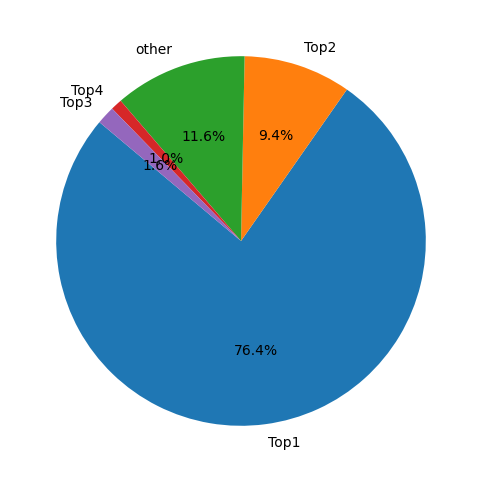

In [205]:
from tqdm import tqdm

pos_rank_list = []

with open('./chatgpt_synthesis/test_merged_hardneg.jsonl', 'r') as input_f:
    lines = input_f.readlines()
    for line in tqdm(lines[:500]):
        json_obj = json.loads(line)
        query = json_obj['query']
        pos = json_obj['pos']
        negs = json_obj['neg']
        neg_pairs = [ [query, neg] for neg in negs ]
        pos_pairs = [[query, pos[0]]]
        
        pos_score = calc_emb_similarity(pos_pairs, smr_client, emb_endpoint_name='bge15-finetuned-2023-09-19-23-59-44-451-endpoint')
        neg_scores = calc_emb_similarity(neg_pairs, smr_client, emb_endpoint_name='bge15-finetuned-2023-09-19-23-59-44-451-endpoint')
        
        neg_scores.sort(reverse=True)
        
        pos_rank = 0
        for item in neg_scores:
            if pos_score < item:
                pos_rank += 1
                
        pos_rank_list.append(pos_rank)
        
plot_stat(pos_rank_list)

* check ranking ability with ranker （查看有ranker模型时的排序效果）

100%|██████████| 500/500 [00:26<00:00, 18.91it/s]


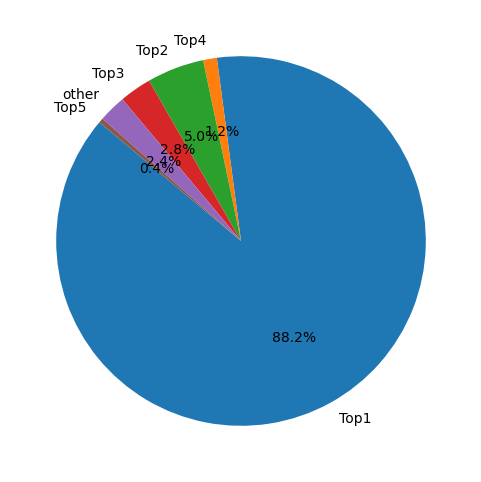

In [208]:
from tqdm import tqdm

pos_rank_list = []
with open('./chatgpt_synthesis/test_merged_hardneg.jsonl', 'r') as input_f:
    lines = input_f.readlines()
    for line in tqdm(lines[:500]):
        json_obj = json.loads(line)
        query = json_obj['query']
        pos = json_obj['pos']
        negs = json_obj['neg']
        neg_pairs = [ [query, neg] for neg in negs ]
        pos_pair = [[query, pos[0]]]
        
        pospair_scores = call_ranker(pos_pair, smr_client, endpoint_name)
        negpair_scores = call_ranker(neg_pairs, smr_client, endpoint_name)
        
        pos_scores = [ item[1] for item in pospair_scores ]
        neg_scores = [ item[1] for item in negpair_scores ]
        neg_scores.sort(reverse=True)
        pos_score = pos_scores[0]
        
        pos_rank = 0
        for item in neg_scores:
            if pos_score < item:
                pos_rank += 1
                
        pos_rank_list.append(pos_rank)

plot_stat(pos_rank_list)
